In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import cv2
import numpy as np
import os
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate,Conv1D, GlobalMaxPooling1D,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
IMG_SIZE = (224, 224)  
MAX_WORDS = 10000  
SEQUENCE_LENGTH = 1  
BREED_CLASSES = 50  
LESIONS_CLASSES = 6
LOCATION_CLASSES = 4

In [3]:
def process_images(image_ids, base_path):
    images = []
    for image_id in tqdm(image_ids, desc='Processing images'):
        img_path = os.path.join(base_path, image_id)
        img = cv2.imread(img_path)
        if img is None:
            print(f'Image not loaded: {img_path}')
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = preprocess_input(img)
        images.append(img)
    return np.array(images)

In [4]:
def process_texts(texts):
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)

In [5]:
label_encoder = LabelEncoder()

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

your_dataframe = pd.read_csv('C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_skin.csv')

# Remove 'Raw data ID' and 'polygon_location' columns
your_dataframe = your_dataframe.drop(columns=['Raw data ID', 'polygon_location'])

# Apply LabelEncoder to each categorical variable
le = LabelEncoder()
your_dataframe['breed'] = le.fit_transform(your_dataframe['breed'])
your_dataframe['gender'] = le.fit_transform(your_dataframe['gender'])
your_dataframe['region'] = le.fit_transform(your_dataframe['region'])

# Define the model
model = DecisionTreeClassifier()

# Prepare the data (X: features, y: target 'lesions')
X = your_dataframe.drop(['lesions'], axis=1)
y = your_dataframe['lesions']

# Train the model
model.fit(X, y)

# Print feature importances
feature_importances = model.feature_importances_
for name, importance in zip(X.columns, feature_importances):
    print(f'Feature: {name}, Importance: {importance}')

Feature: breed, Importance: 0.35898222974851357
Feature: age, Importance: 0.37531295283326266
Feature: gender, Importance: 0.10579042622730368
Feature: region, Importance: 0.1599143911909201


In [6]:
def process_data(data, image_base_path):
    image_data = process_images(data['Raw data ID'], image_base_path)
    age_data = data['age'].values

    breed_labels = to_categorical(label_encoder.fit_transform(data['breed']))
    lesions_labels = to_categorical(label_encoder.fit_transform(data['lesions']))
    region_labels = to_categorical(label_encoder.fit_transform(data['region']))

    return image_data, age_data,  lesions_labels, region_labels

In [8]:
train_data_full = pd.read_csv('C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_skin.csv')
train_data, val_data = train_test_split(train_data_full, test_size=0.2, random_state=42, stratify=train_data_full['breed'])

image_base_path_train = "C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image"

# Process the train data
image_train, age_train, lesions_train = process_data(train_data, image_base_path_train)

# Process the validation data
image_val, age_val, lesions_val = process_data(val_data, image_base_path_train)

Processing images: 100%|█████████████████████████████████████████████████████████| 42536/42536 [16:28<00:00, 43.01it/s]


ValueError: too many values to unpack (expected 3)

In [11]:
# training 데이터를 처리
train_data = pd.read_csv('C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_skin.csv')
image_base_path_train = "C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image"
image_train, age_train, lesions_train, region_train = process_data(train_data, image_base_path_train)

Processing images: 100%|█████████████████████████████████████████████████████████| 53170/53170 [21:08<00:00, 41.91it/s]


In [12]:
# validation 데이터를 처리
val_data = pd.read_csv('C:/Users/oceanlightai/Desktop/datasets/pet_skin/valid/valid_skin.csv')  # 여기에 당신의 validation 데이터의 경로를 입력하세요.
image_base_path_val = "C:/Users/oceanlightai/Desktop/datasets/pet_skin/valid/valid_image"  # 여기에 당신의 validation 이미지들의 경로를 입력하세요.
image_val, age_val, lesions_val, region_val = process_data(val_data, image_base_path_val)

Processing images: 100%|███████████████████████████████████████████████████████████| 6648/6648 [02:22<00:00, 46.54it/s]


In [163]:
# BN + Dropout
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = BatchNormalization()(x)  # BatchNormalization 추가
x = Dropout(0.4)(x)  # Dropout 추가
cnn_model = Model(inputs=base_model.input, outputs=x)

In [164]:
EMBEDDING_DIM = 50

In [165]:
input_text = Input(shape=(1,), dtype='int32')
# 범주 임베딩
x = Embedding(input_dim=7, output_dim=EMBEDDING_DIM)(input_text)
x = Dense(128, activation='relu')(input_text)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
text_model = Model(inputs=input_text, outputs=x)

In [166]:
combined_input = concatenate([cnn_model.output, text_model.output])
x = Dense(128, activation='relu')(combined_input)
x = BatchNormalization()(x)  # BatchNormalization 추가
x = Dropout(0.4)(x)  # Dropout 추가

In [167]:
output_lesions = Dense(LESIONS_CLASSES, activation='softmax', name='lesions')(combined_input)

In [168]:
model = Model(inputs=[cnn_model.input, text_model.input], outputs=[output_lesions])

In [169]:
# 1개 
model.compile(loss={ 'lesions': 'categorical_crossentropy'},
              optimizer=Adam(learning_rate=1e-6), 
              metrics=['accuracy'])

#  base-model

In [162]:
# 기본 ResNet 모델 
img_input = Input(shape=(224, 224, 3))
cnn_model = ResNet50(weights='imagenet', include_top=False, input_tensor=img_input)
img_features = tf.keras.layers.GlobalAveragePooling2D()(cnn_model.output)

In [84]:
VOCAB_SIZE = 5000  
EMBEDDING_DIM = 256  

In [ ]:
# 기본 DNN 모델 
age_input = Input(shape=(1,), dtype='float32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(age_input)
age_features = Dense(128, activation='relu')(age_input)
age_features = GlobalMaxPooling1D()(age_features)

In [25]:
combined = concatenate([img_features, age_features])

In [26]:
# 1개 
output_lesions = Dense(LESIONS_CLASSES, activation='softmax', name='lesions')(combined)

In [ ]:
# 1가지 
model = Model(inputs=[img_input, age_input], outputs=[output_lesions])

In [123]:
# 1개 
model.compile(loss={ 'lesions': 'categorical_crossentropy'},
              optimizer=Adam(learning_rate=1e-6), 
              metrics=['accuracy'])

In [13]:
# 2가지
model = Model(inputs=[img_input, age_input], outputs=[output_lesions, output_region])

In [14]:
# 2개 
model.compile(loss={ 'lesions': 'categorical_crossentropy', 'region': 'categorical_crossentropy'},
              optimizer=Adam(learning_rate=1e-6), metrics=['accuracy'])

In [12]:
# 3개 
output_breed = Dense(BREED_CLASSES, activation='softmax', name='breed')(combined)
output_lesions = Dense(LESIONS_CLASSES, activation='softmax', name='lesions')(combined)
output_region = Dense(LOCATION_CLASSES, activation='softmax', name='region')(combined)

In [ ]:
#3개
model.compile(loss={ 'breed': 'categorical_crossentropy','lesions': 'categorical_crossentropy', 'region': 'categorical_crossentropy'},
              optimizer=Adam(learning_rate=1e-6), metrics=['accuracy'])

In [124]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, mode = 'auto')

In [170]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_30[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [172]:
# 1개
history = model.fit([image_train, age_train], lesions_train,
                    validation_data=([image_val, age_val], lesions_val), 
                    epochs=100, batch_size=32, callbacks = [early_stopping])

Epoch 1/100
1662/1662 [==============================] - 201s 121ms/step - loss: 0.4432 - accuracy: 0.8465 - val_loss: 1.5709 - val_accuracy: 0.4759
Epoch 2/100
1662/1662 [==============================] - 199s 120ms/step - loss: 0.4274 - accuracy: 0.8521 - val_loss: 1.5736 - val_accuracy: 0.4791
Epoch 3/100
1662/1662 [==============================] - 204s 123ms/step - loss: 0.4024 - accuracy: 0.8636 - val_loss: 1.5818 - val_accuracy: 0.4767
Epoch 4/100
1662/1662 [==============================] - 200s 120ms/step - loss: 0.3869 - accuracy: 0.8697 - val_loss: 1.5848 - val_accuracy: 0.4782
Epoch 5/100
1662/1662 [==============================] - 200s 120ms/step - loss: 0.3708 - accuracy: 0.8766 - val_loss: 1.5887 - val_accuracy: 0.4794
Epoch 6/100
1662/1662 [==============================] - 200s 120ms/step - loss: 0.3520 - accuracy: 0.8842 - val_loss: 1.5984 - val_accuracy: 0.4807
Epoch 7/100
1662/1662 [==============================] - 204s 123ms/step - loss: 0.3356 - accuracy: 0.8895

In [16]:
# 2개 
model.fit([image_train, age_train], [lesions_train, region_train], 
          validation_data=([image_val, age_val], [lesions_val, region_val]),
          epochs=10, batch_size=32)

Epoch 1/10
1330/1330 [==============================] - 181s 130ms/step - loss: 2.2020 - lesions_loss: 1.4899 - region_loss: 0.7122 - lesions_accuracy: 0.3944 - region_accuracy: 0.7364 - val_loss: 2.4209 - val_lesions_loss: 1.6269 - val_region_loss: 0.7940 - val_lesions_accuracy: 0.3537 - val_region_accuracy: 0.7006
Epoch 2/10
1330/1330 [==============================] - 180s 135ms/step - loss: 1.9311 - lesions_loss: 1.3480 - region_loss: 0.5831 - lesions_accuracy: 0.4665 - region_accuracy: 0.7864 - val_loss: 2.2034 - val_lesions_loss: 1.4775 - val_region_loss: 0.7259 - val_lesions_accuracy: 0.4357 - val_region_accuracy: 0.7130
Epoch 3/10
1330/1330 [==============================] - 176s 132ms/step - loss: 1.7803 - lesions_loss: 1.2528 - region_loss: 0.5274 - lesions_accuracy: 0.5063 - region_accuracy: 0.8069 - val_loss: 1.9111 - val_lesions_loss: 1.2767 - val_region_loss: 0.6344 - val_lesions_accuracy: 0.4950 - val_region_accuracy: 0.7686
Epoch 4/10
1330/1330 [========================

In [128]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [39]:
def predict_image(images):
    # 이미지 전처리
    images = images/255.0
    # 나이 데이터를 포함하는 더미 배열 생성
    dummy_age = np.zeros((images.shape[0], 1))  # Modify this line
    # 모델 예측
    predictions = model.predict([images, dummy_age])
    # 'lesions' 예측 부분만 반환
    return predictions  # This line was changed

explanation = explainer.explain_instance(image_train[0], predict_image, top_labels=6)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import cv2
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

# 이미지 예측 함수
def predict_fn(images):
    # 나이 데이터를 포함하는 더미 배열 생성
    dummy_age = np.zeros((images.shape[0], 1))  # Modify this line
    # 모델 예측
    predictions = model.predict([images, dummy_age])
    # 'lesions' 예측 부분만 반환
    return predictions

# Load the original image
original_image_path = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image/IMG_D_A1_000016.jpg'  # 이미지 파일 경로를 지정하세요.
original_image = Image.open(original_image_path)

# Get the size of the original image
original_size = original_image.size

# Preprocess the image and make it suitable for the model
preprocessed_image = original_image.resize((224, 224))  # Resize the image
preprocessed_image = np.array(preprocessed_image) / 255.0  # Scale the pixel values
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add a batch dimension

# LIME explanation
explanation = explainer.explain_instance(preprocessed_image[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Resize the LIME explanation to match the original image
lime_image = mark_boundaries(temp / 2 + 0.5, mask)
lime_image_resized = cv2.resize(lime_image, original_size)

# Plot the original image and the LIME explanation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# Original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# LIME explanation
ax[1].imshow(lime_image_resized)
ax[1].set_title('LIME Explanation')

plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [160]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [161]:
loss, accuracy, precision, recall = model.evaluate([image_val, age_val], lesions_val)

208/208 [==============================] - 8s 34ms/step - loss: 1.5831 - accuracy: 0.4788 - precision: 0.5363 - recall: 0.4081


In [37]:
from lime import lime_image

# 이미지 설명자 생성
explainer = lime_image.LimeImageExplainer()

def predict_image(images):
    # 이미지 전처리
    images = images/255.0
    # 나이 데이터를 포함하는 더미 배열 생성
    dummy_age = np.zeros((images.shape[0], 1))  # Modify this line
    # 모델 예측
    predictions = model.predict([images, dummy_age])
    # 'lesions' 예측 부분만 반환
    return predictions[0][:, :LESIONS_CLASSES] # lesions를 예측하는 첫 번째 출력의 일부를 반환

explanation = explainer.explain_instance(image_train[0], predict_image, top_labels=LESIONS_CLASSES)

  0%|          | 0/1000 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


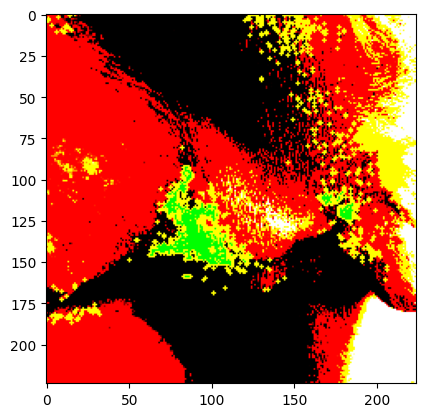

In [87]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

# 이미지 데이터에 대한 설명 생성
def predict_fn(images):
    # create a batch of ages with the same size as images batch
    dummy_ages = np.full((images.shape[0], 1), np.mean(age_train))
    # Make sure to return the probabilities
    predictions = model.predict([images, dummy_ages])
    return predictions[0]  # Return the probabilities for 'lesions'

explanation = explainer.explain_instance(image_train[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


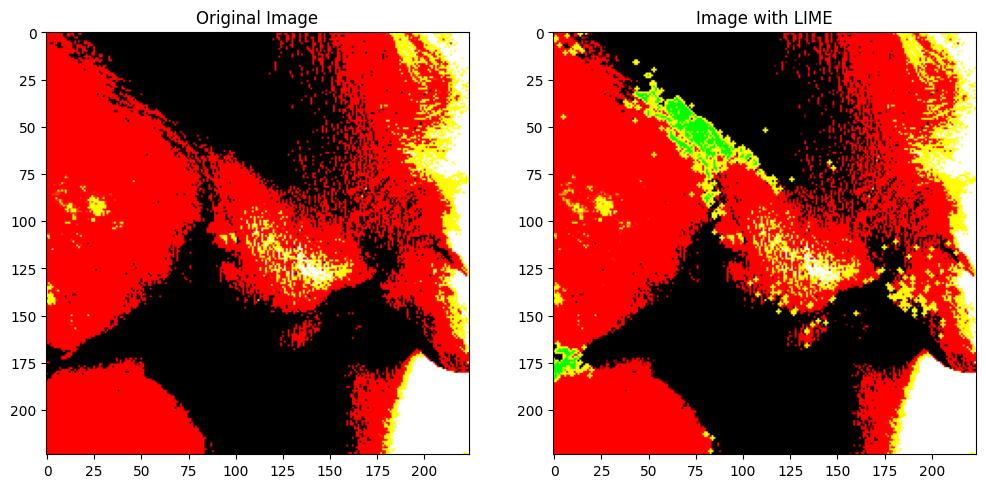

In [93]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

# 이미지 데이터에 대한 설명 생성
def predict_fn(images):
    # create a batch of ages with the same size as images batch
    dummy_ages = np.full((images.shape[0], 1), np.mean(age_train))
    # Make sure to return the probabilities
    predictions = model.predict([images, dummy_ages])
    return predictions[0]  # Return the probabilities for 'lesions'

explanation = explainer.explain_instance(image_train[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 원본 이미지 출력
original_image = image_train[0]
original_image = (original_image * 255).astype(np.uint8)  # 전처리 과정에서 스케일링을 되돌림
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# LIME 결과 출력
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('Image with LIME')

plt.show()

In [40]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()


# Load the original image
original_image_path = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image/IMG_D_A1_000001.jpg'  # 이미지 파일 경로를 지정하세요.
original_image = Image.open(original_image_path)

# Get the size of the original image
original_size = original_image.size

# Preprocess the image and make it suitable for the model
preprocessed_image = original_image.resize((224, 224))  # Resize the image
preprocessed_image = np.array(preprocessed_image) / 255.0  # Scale the pixel values
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add a batch dimension

# LIME explanation
explanation = explainer.explain_instance(preprocessed_image[0], 
                                         predict_fn, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=6, hide_rest=False)

# Resize the LIME explanation to match the original image
lime_image = mark_boundaries(temp / 2 + 0.5, mask)
lime_image_resized = cv2.resize(lime_image, original_size)

# Plot the original image and the LIME explanation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# Original image
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# LIME explanation
ax[1].imshow(lime_image_resized)
ax[1].set_title('LIME Explanation')

plt.show()

NameError: name 'predict_fn' is not defined